In [14]:
import numpy as np
import matplotlib.pyplot as plt


# ReLU layer class
class ReLU:
    '''
    A class representing the Rectified Linear Unit (reLu) activation function.
    '''
    def __init__(self):
        self.input = None # placeholder for storing the input to the layer

    def forward_pass(self, input_data):
        self.input = input_data # store the input to use it in the backward pass
        return np.maximum(0, input_data) # apply the relu function: if x is negative, max(0, x) will be 0; otherwise, will be x

    def backward_pass(self, output_gradient):
        '''
        Compute the backward pass through the reLu activation function.

        The method calculates the gradient of the reLu function with respect 
        to its input 'x', given the gradient of the loss function with respect 
        to the output of the relu layer ('gradient_values').

        Parameters:
        - gradient_values (numpy.ndarray): The gradient of the loss function with respect 
                                           to the output of the relu layer.

        Returns:
        - numpy.ndarray: The gradient of the loss function with respect to the 
                         input of the relu layer.
        '''
        # apply the derivative of the relu function: if the input is negative, the derivative is 0; otherwise, the derivative is 1
        return output_gradient * (self.input > 0)
        #return output_gradient * np.where(self.input > 0, 1.0, 0.0) 

In [15]:
# Sigmoid layer class
class Sigmoid:
    '''
    A class representing the Sigmoid activation function.
    '''
    def __init__(self):
        self.output = None # placeholder for storing the output of the forward pass

    def forward_pass(self, input_data):
        self.output = 1 / (1 + np.exp(-input_data)) # apply the sigmoid function: f(x) = 1 / (1 + exp(-x))
        return self.output

    def backward_pass(self, output_gradient):
        '''
        Computes the backward pass of the Sigmoid activation function.

        Given the gradient of the loss function with respect to the output of the
        Sigmoid layer ('output_gradient'), this method calculates the gradient with respect
        to the Sigmoid input.

        Parameters:
        - output_gradient (numpy.ndarray): The gradient of the loss function with respect
                                           to the output of the Sigmoid layer.

        Returns:
        - numpy.ndarray: The gradient of the loss function with respect to the
                         input of the Sigmoid layer.
        '''
        return output_gradient * (self.output * (1 - self.output))

In [16]:
# Softmax layer class
class Softmax:
    '''
    A class representing the Softmax activation function.
    '''

    def forward_pass(self, input_data):
        '''
        Computes the forward pass of the Softmax activation function.

        Parameters:
        - input_data (numpy.ndarray): A numpy array containing the input data to which the Softmax
                             function should be applied.

        Returns:
        - numpy.ndarray: The result of applying the Softmax function to 'input_data', with the
                         same shape as 'input_data'.
        ''' 
        exp_values = np.exp(input_data - np.max(input_data, axis=1, keepdims=True)) # Shift the input data to avoid numerical instability in exponential calculations
        output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return output

    def backward_pass(self, dvalues):
        # The gradient of loss with respect to the input logits 
        # directly passed through in case of softmax + categorical cross-entropy
        return dvalues

In [17]:
class Dropout:    
    def __init__(self, probability):
        self.probability = probability
        
    def forward_pass(self, input_data):
        self.mask = np.random.binomial(1, 1-self.probability, size=input_data.shape) / (1-self.probability)
        return input_data * self.mask
    
    def backward_pass(self, output_gradient):
        return output_gradient * self.mask

In [18]:
# Dense layer class
class Layer:
    def __init__(self, input_size, output_size):
        self.weights = 0.01 * np.random.normal(0, 1/np.sqrt(input_size), (input_size, output_size)) # Normal distribution initialisation
        self.biases = np.full((1, output_size), 0.001) # Initialise biases with a small positive value
        self.input = None

    def forward_pass(self, input_data):
        self.input = input_data
        return np.dot(input_data, self.weights) + self.biases

    def backward_pass(self, output_gradient, learning_rate):
        '''
        Computes the backward pass of the Dense layer.

        Parameters:
        - output_gradient: The gradient of the loss function with respect to the output of the layer.

        - learning_rate: A hyperparameter that controls how much the weights and biases are updated during training.

        Returns:
        - numpy.ndarray: the gradient of the loss with respect to the layer's inputs (which will be passed back to the previous layer in the network).
        ''' 
        weights_gradient = np.dot(self.input.T, output_gradient)
        input_gradient = np.dot(output_gradient, self.weights.T)
        biases_gradient = np.sum(output_gradient, axis=0, keepdims=True)

        # Update weights and biases
        self.weights += learning_rate * weights_gradient
        self.biases += learning_rate * biases_gradient

        return input_gradient


In [28]:
# Neural Network wrapper class
class NeuralNetwork:
    def __init__(self):
        self.layers = [] # placeholder for storing the layers of the network so we can propagate the infomation in a sequential order
        self.loss_history = [] # placegolder to store the loss for plotting

    def add_layer(self, layer):
        '''
        Add the layer to the network
        '''
        self.layers.append(layer)

    def forward_pass(self, input_data):
        '''
        Performs a forward pass through the network. 
        It sequentially passes the input data through each layer, transforming it according to each layer's operation.
        '''
        for layer in self.layers:
            input_data = layer.forward_pass(input_data)
        return input_data
    
    def prediction(self, input_data):
        '''
        Performs a forward pass through the network ignoring the dropout.
        '''
        for layer in self.layers:
            if not isinstance(layer, Dropout):
                input_data = layer.forward_pass(input_data)
        return input_data

    def backward_pass(self, output_gradient, learning_rate):
        '''
        Performs the backward pass (backpropagation) for training. 
        It propagates the gradient of the loss function backward through the network, updating weights in the process if the layer is a dense one.

        Parameters:
        - output_gradient: The gradient of the loss function with respect to the network's output.

        - learning_rate: The step size for weight updates.
        '''
        for layer in reversed(self.layers):
            if isinstance(layer, Layer):
                output_gradient = layer.backward_pass(output_gradient, learning_rate)
            else:
                output_gradient = layer.backward_pass(output_gradient)
    
    def compute_categorical_cross_entropy_loss(self, y_pred, y_true):
        '''
        Computes the categorical cross entropy loss
        '''
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7) # Clip predictions to prevent log(0)

        # Calculate the negative log of the probabilities of the correct class
        # Multiply with the one-hot encoded true labels and sum across classes
        loss = np.sum(y_true * -np.log(y_pred_clipped), axis=1)

        # Average loss over all samples
        return np.mean(loss)

    def compute_categorical_cross_entropy_gradient(self, y_pred, y_true):
        '''
        Calculates the gradient of the categorical cross entropy loss with respect to the network's output, assuming that the output layer is the softmax activation function.

        Parameters:
        - y_pred: Output of the softmax activation function.

        - y_true: One-hot encoded label array.
        '''
        # Assuming y_true is one-hot encoded and y_pred is the output of softmax
        y_pred_gradient = (y_pred - y_true) / len(y_pred)
        return y_pred_gradient

    def train(self, X_train, y_train, epochs=100, learning_rate=0.001, batch_size=32, verbose = 1):
        '''
        Conducts the training process over a specified number of epochs.

        Parameters:
        - X_train: The input features of the training data.

        - y_train: The target output (labels) of the training data.

        - epochs: The number of times the entire training dataset is passed forward and backward through the neural network.

        - learning_rate: The step size at each iteration while moving toward a minimum of the loss function.

        - batch_size: The number of training examples used in one iteration.

        - verbose: The mode of verbosity (0 = silent, 1 = update every 10 epochs, 2 = update every epoch).
        '''
        n_samples = len(X_train)
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            for start_idx in range(0, n_samples, batch_size):
                end_idx = min(start_idx + batch_size, n_samples)
                batch_x = X_train[start_idx:end_idx]
                batch_y = y_train[start_idx:end_idx]

                output = self.forward_pass(batch_x)
                loss_gradient = self.compute_categorical_cross_entropy_gradient(batch_y, output)
                self.backward_pass(loss_gradient, learning_rate)

            output = self.forward_pass(X_train)
            loss = self.compute_categorical_cross_entropy_loss(y_train, output)
            self.loss_history.append(loss)

            if verbose == 1:
                if epoch % 10 == 0:
                    print(f"Epoch {epoch}/{epochs} --- Loss: {loss}")
            elif verbose == 2:
                print(f"Epoch {epoch}/{epochs} --- Loss: {loss}")
            epoch += 1

    def predict(self, X_test):
        output = self.prediction(X_test)

        # Convert probabilities to class predictions
        predictions = np.argmax(output, axis=1)
        return predictions

    def plot_loss(self):
        '''
        Plots the loss history stored in self.loss_history over the epochs.
        '''
        plt.plot(self.loss_history)
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()


In [29]:
def standardize_data(X):
    # Calculate the mean and standard deviation for each feature
    means = X.mean(axis=0)
    stds = X.std(axis=0)

    # Avoid division by zero in case of a constant feature
    stds[stds == 0] = 1

    # Standardize each feature
    X_standardized = (X - means) / stds
    return X_standardized

c:\Users\aless\miniconda3\envs\IntroductionToAI\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0/200 --- Loss: 14.505399332952601
Epoch 10/200 --- Loss: 6.639191571194193
Epoch 20/200 --- Loss: 2.450448246155132
Epoch 30/200 --- Loss: 1.4275895784051285
Epoch 40/200 --- Loss: 1.1138967807235596
Epoch 50/200 --- Loss: 0.8478670346046957
Epoch 60/200 --- Loss: 0.7564949041647251
Epoch 70/200 --- Loss: 0.6677058457768406
Epoch 80/200 --- Loss: 0.5165143308708674
Epoch 90/200 --- Loss: 0.5140322525567442
Epoch 100/200 --- Loss: 0.4492882185684458
Epoch 110/200 --- Loss: 0.3890707817950642
Epoch 120/200 --- Loss: 0.35468647441103035
Epoch 130/200 --- Loss: 0.34119704500746806
Epoch 140/200 --- Loss: 0.30075267490161395
Epoch 150/200 --- Loss: 0.27531559296325897
Epoch 160/200 --- Loss: 0.2571090399327928
Epoch 170/200 --- Loss: 0.28495044674389547
Epoch 180/200 --- Loss: 0.2274065718587537
Epoch 190/200 --- Loss: 0.22287512014477814


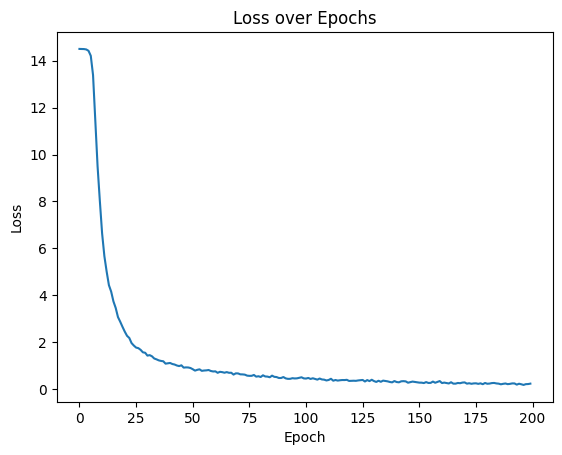

[6 9 3]
[6 9 3]

Accuracy: 0.9777777777777777


In [30]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

# Standardize the features
X = standardize_data(X)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse=False)
y = one_hot_encoder.fit_transform(y.reshape(-1, 1))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
network = NeuralNetwork()
network.add_layer(Layer(64, 128))  # 64 inputs (8x8 images)
network.add_layer(ReLU())
network.add_layer(Dropout(0.25))
network.add_layer(Layer(128, 10))  # 10 classes
network.add_layer(Softmax())

# Train the network
network.train(X_train, y_train, epochs=200, learning_rate=0.01, batch_size=10)

network.plot_loss()

# Evaluate the performance of the model
y_pred = network.predict(X_test)
y_test = np.argmax(y_test, axis=1) # transoform back the One-Hot encoded array of the labels

accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy}")

c:\Users\aless\miniconda3\envs\IntroductionToAI\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 0/20000 --- Loss: 8.053266721096405
Epoch 10/20000 --- Loss: 7.963567522190622
Epoch 20/20000 --- Loss: 7.881871852299028
Epoch 30/20000 --- Loss: 7.780280698083434
Epoch 40/20000 --- Loss: 7.560271588940646
Epoch 50/20000 --- Loss: 6.903631202560784
Epoch 60/20000 --- Loss: 5.582530195528522
Epoch 70/20000 --- Loss: 4.332261581910845
Epoch 80/20000 --- Loss: 3.5006796334622208
Epoch 90/20000 --- Loss: 2.9659928823497705
Epoch 100/20000 --- Loss: 2.5976959903311054
Epoch 110/20000 --- Loss: 2.327880692072756
Epoch 120/20000 --- Loss: 2.1185382515603273
Epoch 130/20000 --- Loss: 1.9505045963655423
Epoch 140/20000 --- Loss: 1.8135876769846926
Epoch 150/20000 --- Loss: 1.698907253841939
Epoch 160/20000 --- Loss: 1.6018412267465656
Epoch 170/20000 --- Loss: 1.5188789823703641
Epoch 180/20000 --- Loss: 1.4467605969915125
Epoch 190/20000 --- Loss: 1.3837495690558774
Epoch 200/20000 --- Loss: 1.3290570976138072
Epoch 210/20000 --- Loss: 1.2800623637544275
Epoch 220/20000 --- Loss: 1.235

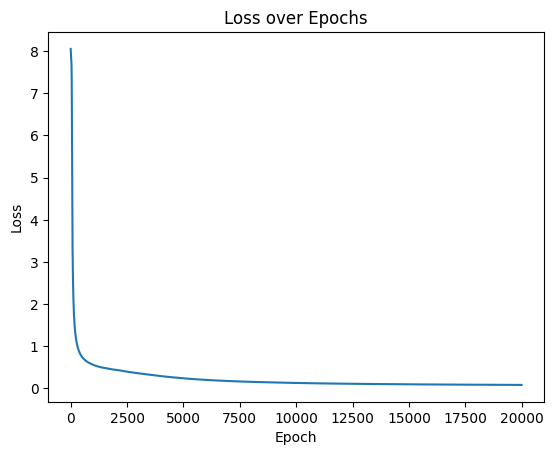


Accuracy: 0.9736842105263158


In [27]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

X = dataset.data
y = dataset.target

# Standardize the features
X = standardize_data(X)

# One-hot encode the labels
one_hot_encoder = OneHotEncoder(sparse=False)
y = one_hot_encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the neural network model
network = NeuralNetwork()
network.add_layer(Layer(X_train.shape[1], 128))  # 64 inputs (8x8 images)
network.add_layer(ReLU())
network.add_layer(Layer(128, 2))  # 1 classes
network.add_layer(Sigmoid())

# Train the network
network.train(X_train, y_train, epochs=200, learning_rate=0.01, batch_size=16)

network.plot_loss()

# Evaluate the performance of the model
y_pred = network.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy}")

# Next Step

* L1 and L2 regularizers

* validation loss

* optimization of hyperparameters (random search and grid search function?)